In [1]:
from diffusers import StableDiffusionXLPipeline
import torch
import importlib
import sd_hooks
import utils
importlib.reload(sd_hooks)
importlib.reload(utils)
from sd_hooks import SDHiddenRecorder
from typing import Literal
from modules import namespace
from typing import Literal
import matplotlib.pyplot as plt

In [42]:
pipeline: StableDiffusionXLPipeline = StableDiffusionXLPipeline.from_single_file(
    "/root/ComfyUI/models/checkpoints/animagine-xl-3.1.safetensors", 
    torch_dtype=torch.float16, 
    variant="fp16", 
    safety_checker=None, 
    config='/root/ComfyUI/models/checkpoints/Animagine3.1',
).to("cuda")
pipeline.load_lora_weights("/root/ComfyUI/models/loras/firefly_V3.safetensors", adapter_name="my_adapter")
torch.manual_seed(42)
scales = {
    "text_encoder": 0.5,
    "text_encoder_2": 0.5,  # only usable if pipe has a 2nd text encoder
    "unet": {
        "down": 0.9,  # all transformers in the down-part will use scale 0.9
        # "mid"  # in this example "mid" is not given, therefore all transformers in the mid part will use the default scale 1.0
        "up": 0.9
    }
}
pipeline.set_adapters("my_adapter", scales)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
hidden_ids = [
    'up_blocks.0.resnets.0',
    'up_blocks.0.resnets.1',
    'up_blocks.0.resnets.2',
    'up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q',
    'up_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q',
    'up_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k',
    'mid_block'
]
def record_a_generating_process(pipeline, hidden_ids, prompt, n_prompt, seed, height = 1080, width = 720):
    generator = torch.Generator("cuda").manual_seed(seed)
    recorder = SDHiddenRecorder(pipeline, hidden_ids)
    with torch.no_grad():
        image = pipeline(
            prompt=prompt, 
            negative_prompt=n_prompt,
            height=height,
            width=width,
            num_inference_steps=20,
            callback_on_step_end=recorder,
            generator=generator
        ).images[0]
    return recorder, image

In [32]:
prompt = "firefly_(honkai:_star_rail), 1 girl, looking at viewer"
negative_prompt = "bad anatomy,blurry,worst quality,low quality,hands bad,face bad,bad hands,mutated hands and fingers,extra legs,extra arms,duplicate,cropped,text,jpeg,artifacts,signature,watermark,username,blurry,artist name,trademark,title,multiple view,Reference sheet,long body,multiple breasts,mutated,bad anatomy,disfigured,bad proportions,duplicate,bad feet,artist name,ugly,text font ui,missing limb,monochrome,"

In [61]:
from collections import OrderedDict
pipeline.unet._forward_hooks = OrderedDict()
pipeline.unet._forward_pre_hooks = OrderedDict()

In [62]:
tokens = pipeline.tokenizer.tokenize(prompt)
def unet_input_modifier(module, input):
    print(input[1])
handle = pipeline.unet.register_forward_pre_hook(unet_input_modifier)

In [63]:
recorder, image = record_a_generating_process(pipeline, hidden_ids, prompt, negative_prompt, 42)

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(951., device='cuda:0')
tensor(901., device='cuda:0')
tensor(851., device='cuda:0')
tensor(801., device='cuda:0')
tensor(751., device='cuda:0')
tensor(701., device='cuda:0')
tensor(651., device='cuda:0')
tensor(601., device='cuda:0')
tensor(551., device='cuda:0')
tensor(501., device='cuda:0')
tensor(451., device='cuda:0')
tensor(401., device='cuda:0')
tensor(351., device='cuda:0')
tensor(301., device='cuda:0')
tensor(251., device='cuda:0')
tensor(201., device='cuda:0')
tensor(151., device='cuda:0')
tensor(101., device='cuda:0')
tensor(51., device='cuda:0')
tensor(1., device='cuda:0')


In [24]:
a = recorder.hiddens[19]['up_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k'][1]
torch.norm(a[65]-a[66], p=2)

tensor(28.0781, dtype=torch.float16)

In [56]:
print(tokens[13])

looking</w>


['firefly</w>', '_(</w>', 'hon', 'kai</w>', ':', '_</w>', 'star</w>', '_</w>', 'rail</w>', ')</w>']


/root/SDXLDecomposer/utils.py:39: RuntimeWarning: invalid value encountered in cast
  grid_image = Image.fromarray((grid_image * 255).astype('uint8'))


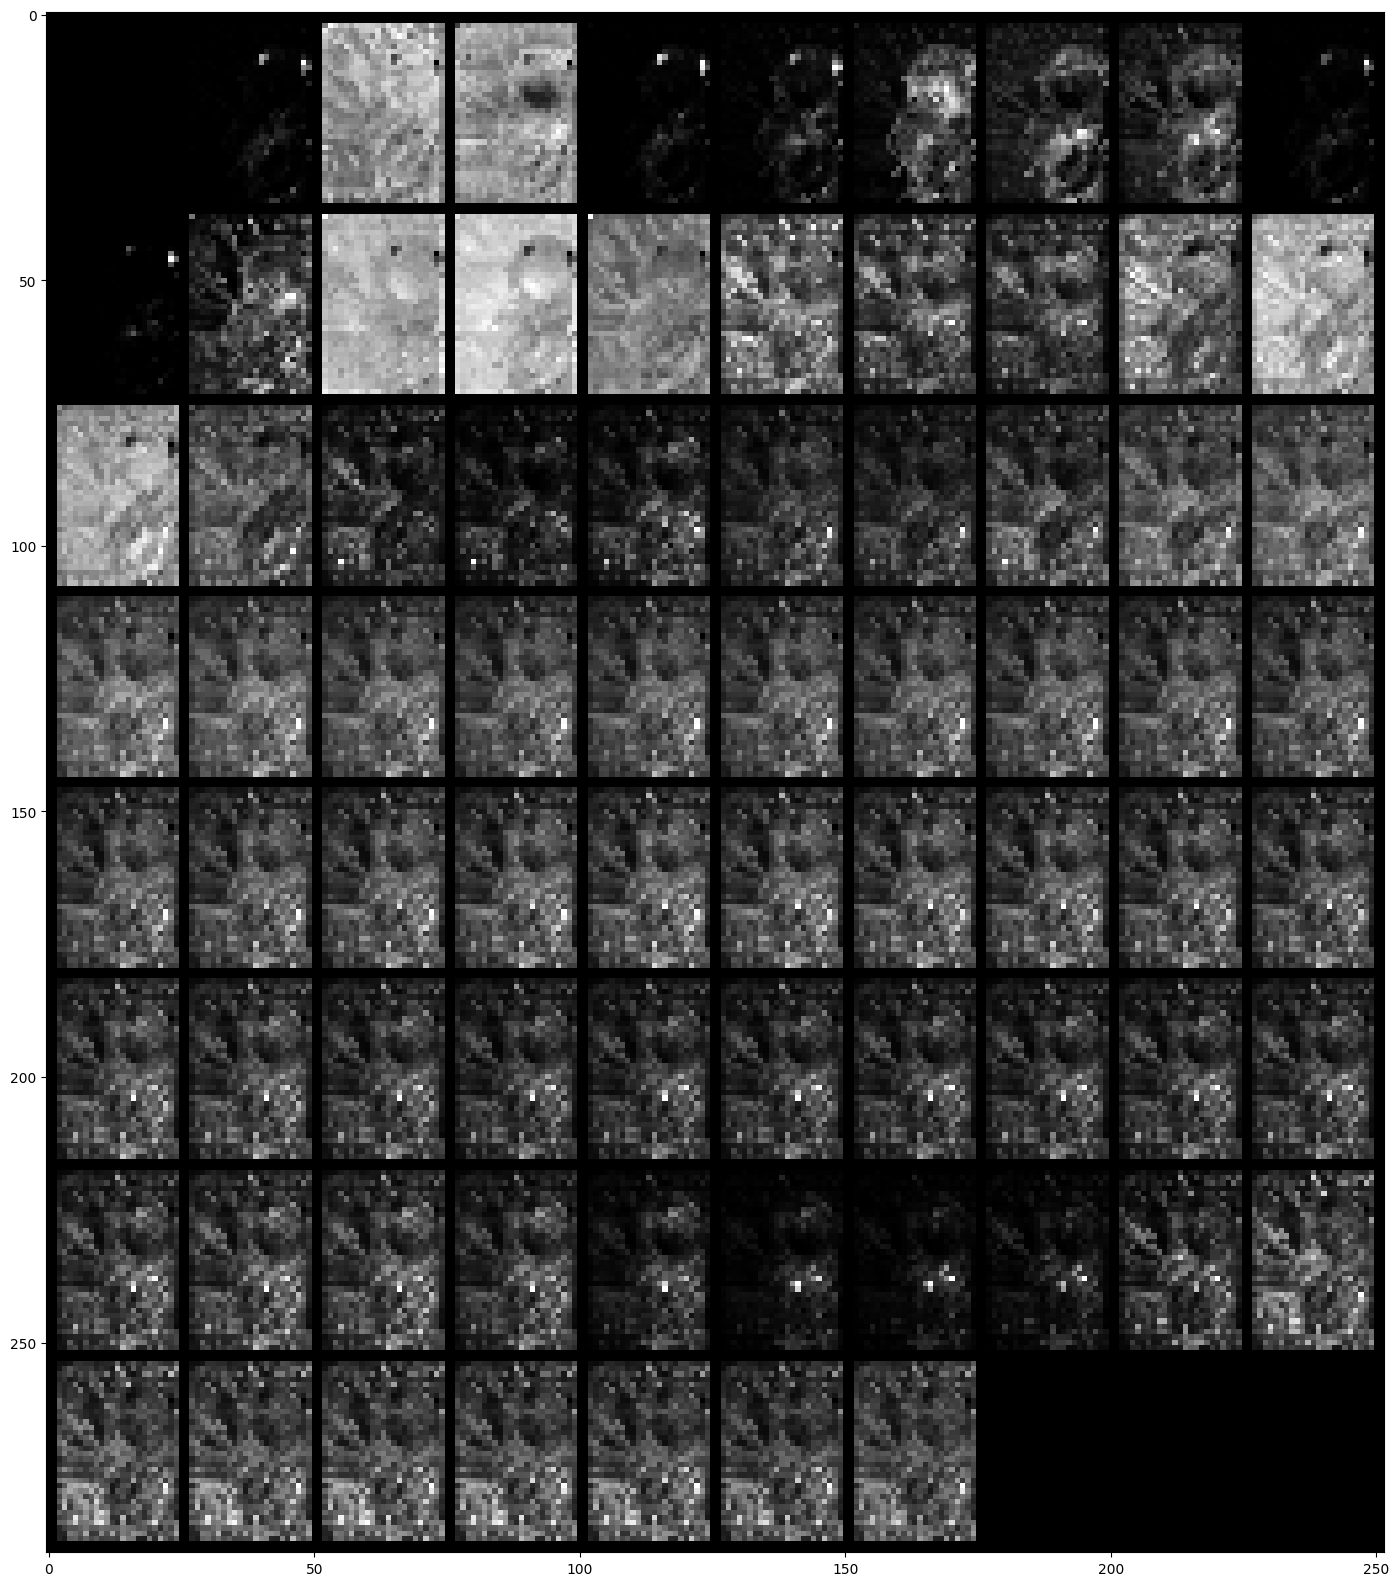

In [27]:
recorder.__class__ = SDHiddenRecorder
img, tokens = recorder.last_step_cross_attn_map_visualization('up_blocks.0.attentions.0.transformer_blocks.0.attn2', prompt, temperature=0.1)
print(tokens)
plt.figure(figsize=(20, 20))
plt.imshow(img)

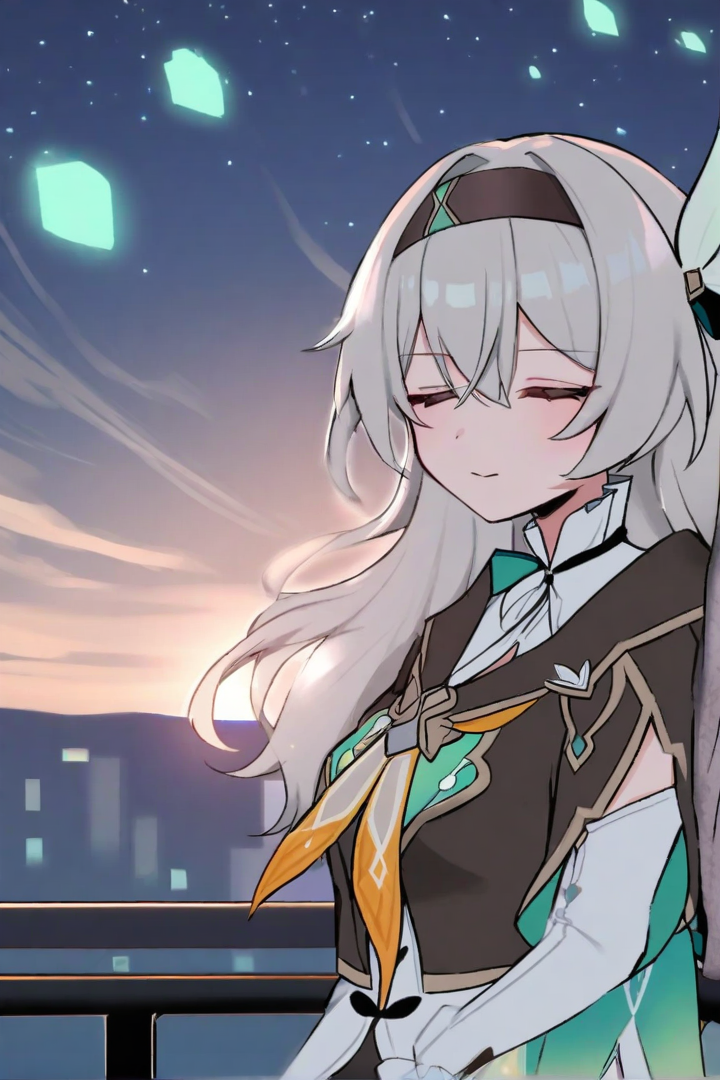

In [28]:
image

  0%|          | 0/20 [00:00<?, ?it/s]

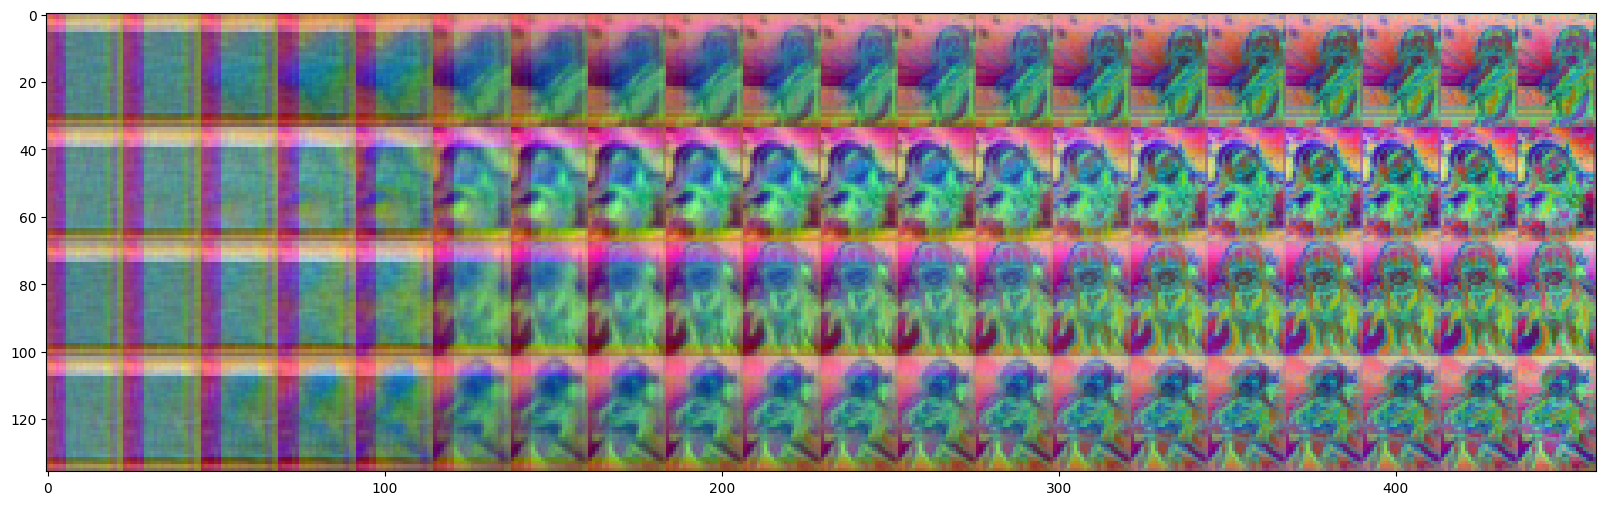

In [125]:

result = SDHiddenRecorder.joint_feature_visualization(
    [recorder1, recorder2, recorder3, recorder4], 
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q', 
    show=False
)
plt.figure(figsize=(20, 10))
plt.imshow(result)

In [85]:
recorder1.pipe.tokenizer.tokenize('firefly_(honkai:_star_rail), 1 girl, looking at viewer, upper body, background')

['firefly</w>',
 '_(</w>',
 'hon',
 'kai</w>',
 ':',
 '_</w>',
 'star</w>',
 '_</w>',
 'rail</w>',
 '),</w>',
 '1</w>',
 'girl</w>',
 ',</w>',
 'looking</w>',
 'at</w>',
 'viewer</w>',
 ',</w>',
 'upper</w>',
 'body</w>',
 ',</w>',
 'background</w>']

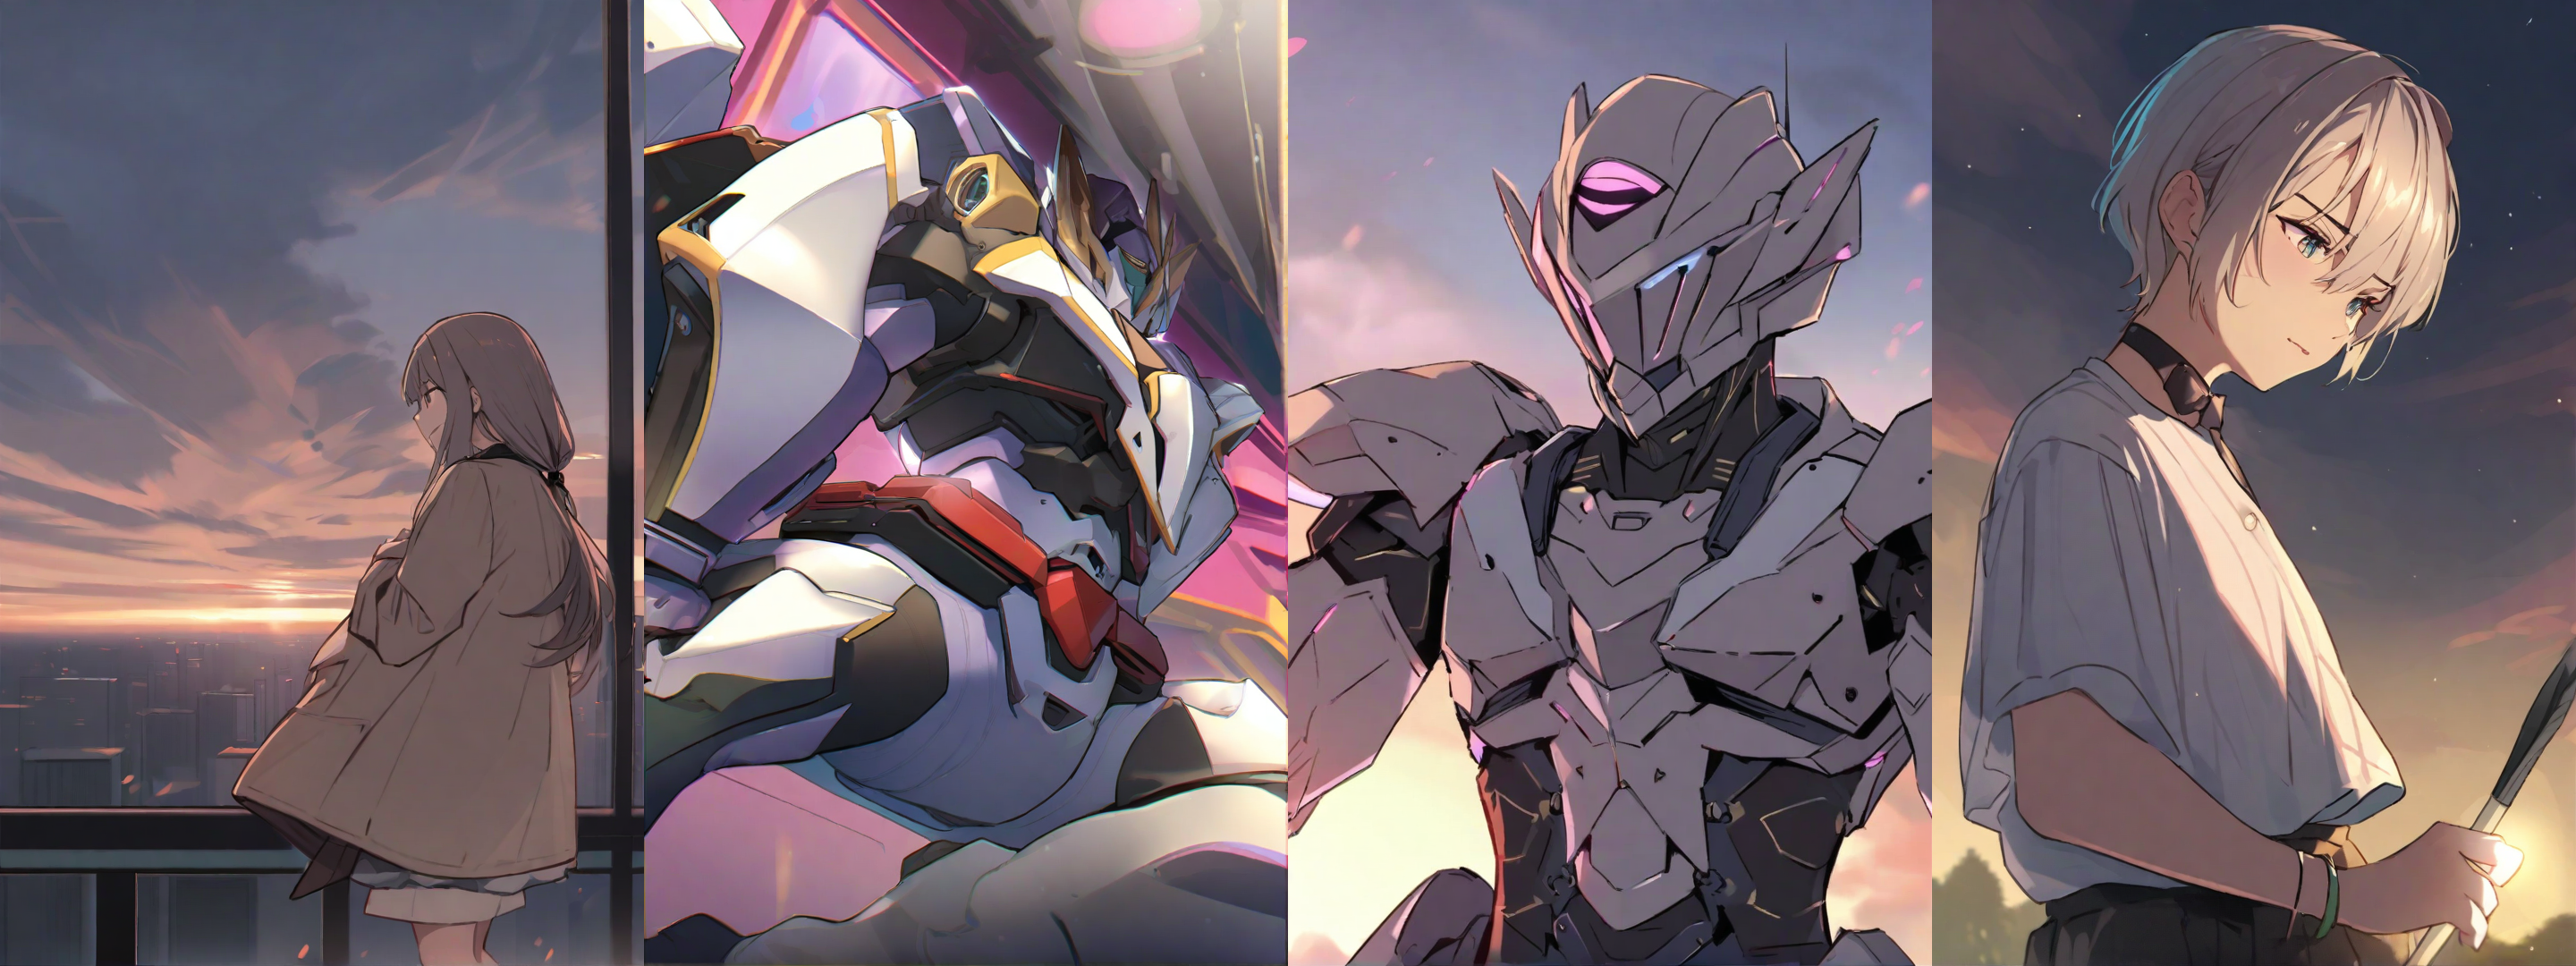

In [6]:
from diffusers.utils import make_image_grid
display(make_image_grid([image1, image2, image3, image4], rows=1, cols=4))